In [1]:
from collections import Counter

import pandas as pd
from matplotlib import pyplot

from sklearn.model_selection import train_test_split
from sklearn.tree import DecisionTreeClassifier 
from sklearn.naive_bayes import GaussianNB 
from sklearn.preprocessing import LabelEncoder
from sklearn.metrics import plot_confusion_matrix
from imblearn.over_sampling import SMOTE


### What is being done here
1. Create a dataset with both df_train & df_test only demographic columns (-weight and height as bmi which is a derived column is included)
2. Remove all null and invalid rows
3. Created age bins so that the distribution is not too imbalanced
4. Convert categorical columns to dummy columns 
5. Build classifiers with and w/o SMOTE using 
    - Decision Tree model
    - Build Gaussian Naive Bayes model

Removed bmi, ethnicity: No improvement

### Common functions

In [2]:
TEST_DS_SIZE = 0.2
DEMO1_COLS = ['encounter_id', 'age', 'gender', 'weight', 'height'] #, 'ethnicity''bmi']
DT_DEPTH = 2


In [3]:
AGE_LABELS = [ '(-0.1, 0]',
               '(0, 12.9]',
               '(12.9, 40.0]',
               '(40.0, 50.0]',
               '(50.0, 60.0]',
               '(60.0, 70.0]',
               '(70.0, 80.0]',
               '(80.0, 120.0]']
'''
17.9]',
               '(17.9, 30.0]',
               '(30.0,
17.9, 30,
'''
def AGE_BINS(df):
      return pd.cut(df['age'], [-0.1, 0, 12.9,  40, 50, 60, 70, 80, 120], labels=AGE_LABELS)

def _agedist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['age'].isnull()].shape[0]
    nan_pc = nan_count/total_count

    ages = df['age'].unique()
    ages.sort()
    # Since age has 0.0 values, these should be ignored/replaced
    min_age = ages[1]
    print(f"Invalid age: {df[df['age']==0.0]['age'].count()} Min: {df['age'].min():0.2f} Max: {df['age'].max():0.2f}")

    # Group the ages based on the age-groups
    #bins = pd.cut(df['age'], AGE_BINS)
    df_age = df.groupby(AGE_BINS(df))['age'].agg(['count'])
    df_age = df_age.reset_index()

    # Append the null value counts
    df_age = df_age.append(pd.DataFrame([['null', nan_count]], columns = ['age', f'count']))

    # Add a percentage column
    df_age[f'{df_name}_%'] = 100 * df_age['count']/total_count
    df_age = df_age.rename(columns = {'count':f"{df_name}_count"})

    df_age.plot.bar(x='age', y='total_count')

    #print(df_age)
    print(f"Verification:   {df_name}_count: {df_age[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_age[f'{df_name}_%'].sum():0.1f}%")
    return df_age, nan_count, nan_pc

# underweight, normal, overweight, obese
BMI_LABELS = [ '[0.0 - 18.5] underweight',
               '[18.5 - 24.9] normal weight',
               '[25 -  30] over weight',
               '[70  <] obese']

def BMI_BINS(df):
      return pd.cut(df['bmi'], [0, 18.5, 24.9, 30, 70], labels=BMI_LABELS)

def _bmidist(df, df_name):
    total_count = df.shape[0]
    nan_count = df[df['bmi'].isnull()].shape[0]
    nan_pc = nan_count/total_count
    print(f"Min: {df['bmi'].min():0.2f} Max: {df['bmi'].max():0.2f}")

    # Group the values based on the bmi-categories
    #bins = pd.cut(df['bmi'], BMI_BINS, labels=BMI_LABELS)
    df_bmi = df.groupby(BMI_BINS(df))['bmi'].agg(['count'])
    df_bmi = df_bmi.reset_index()

    # Append the null value counts
    df_bmi = df_bmi.append(pd.DataFrame([['null', nan_count]], columns = ['bmi', f'count']))

    # Add a percentage column
    df_bmi[f"{df_name}_%"] = 100 * df_bmi['count']/total_count
    df_bmi = df_bmi.rename(columns = {'count':f"{df_name}_count"})

    print(df_bmi)
    print(f"Verification:   {df_name}_count: {df_bmi[f'{df_name}_count'].sum()} "
          f"{df_name}_%: {df_bmi[f'{df_name}_%'].sum():0.1f}%")
    return df_bmi, nan_count, nan_pc

def oversample(X, y):
      # transform the dataset
      oversample = SMOTE()
      X, y = oversample.fit_resample(X, y)
      # summarize distribution
      counter = Counter(y)
      for k,v in counter.items():
            per = v / len(y) * 100
            print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
      return X,y,counter

def predictWithDecisionTree(X_train, y_train, X_test, y_test):
    dtree_model = DecisionTreeClassifier(max_depth = DT_DEPTH).fit(X_train, y_train) 
    dtree_predictions = dtree_model.predict(X_test) 
    # accuracy on X_test 
    accuracy = dtree_model.score(X_test, y_test) 
    print(accuracy) 
    plot_confusion_matrix(dtree_model, X_test, y_test) 
    return accuracy

def predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test):
      gnb = GaussianNB().fit(X_train, y_train) 
      gnb_predictions = gnb.predict(X_test) 

      # accuracy on X_test 
      accuracy = gnb.score(X_test, y_test) 
      print(accuracy) 
      plot_confusion_matrix(gnb, X_test, y_test) 
      return accuracy

#### Combine the train and the unlabelled datasets (only demographic columns)
- Remove rows with invalid ages (30) 
- Remove null rows

In [4]:
df_train = pd.read_csv("data/TrainingWiDS2021.csv", usecols = DEMO1_COLS)
df_train.shape[0]

130157

In [5]:
df_unlabeled = pd.read_csv("data/UnlabeledWiDS2021.csv", usecols = DEMO1_COLS)
df_unlabeled.shape[0]

10234

In [6]:
df_total = pd.concat([df_train, df_unlabeled])
df_total.shape[0]

140391

Invalid age: 30 Min: 0.00 Max: 96.00
Verification:   total_count: 140391 total_%: 100.0%


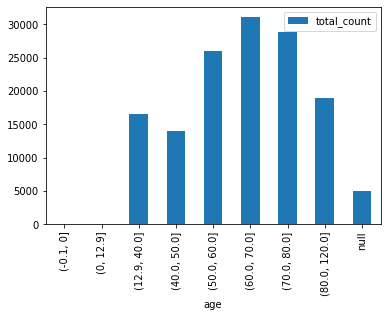

In [7]:
df_age, _, _  = _agedist(df_total, 'total')

In [8]:
df_age

,age,total_count,total_%
0,"(-0.1, 0]",30,0.021369
1,"(0, 12.9]",0,0.000000
2,"(12.9, 40.0]",16508,11.758589
3,"(40.0, 50.0]",14017,9.984258
4,"(50.0, 60.0]",25925,18.466283
5,"(60.0, 70.0]",31063,22.126062
6,"(70.0, 80.0]",28901,20.586077
7,"(80.0, 120.0]",18959,13.504427
0,null,4988,3.552934


In [9]:
#_bmidist(df_total, 'total')

In [10]:
df_total = df_total[(df_total['age']!=0.0) & (df_total['age'].notnull())]
df_total.shape[0]

135373

Invalid age: 0 Min: 16.00 Max: 96.00
Verification:   total_count: 135373 total_%: 100.0%


(             age  total_count    total_%
 0      (-0.1, 0]            0   0.000000
 1      (0, 12.9]            0   0.000000
 2   (12.9, 40.0]        16508  12.194455
 3   (40.0, 50.0]        14017  10.354354
 4   (50.0, 60.0]        25925  19.150791
 5   (60.0, 70.0]        31063  22.946230
 6   (70.0, 80.0]        28901  21.349161
 7  (80.0, 120.0]        18959  14.005008
 0           null            0   0.000000,
 0,
 0.0)

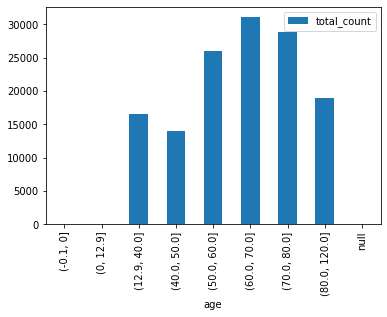

In [11]:
_agedist(df_total, 'total')

In [12]:
df_total.groupby(['age', 'gender']).agg(['count']) # , 'ethnicity'

encounter_id height weight
                   count  count  count
age  gender                           
16.0 F                47     46     45
     M                38     37     37
17.0 F                88     85     85
     M                92     89     90
18.0 F               211    207    196
...                  ...    ...    ...
94.0 M                19     17     16
95.0 F                17     16     14
     M                12     11     10
96.0 F                18     18     18
     M                14     13     14

[162 rows x 3 columns]

In [13]:
df_total[df_total.isnull().any(axis=1)].count()

encounter_id    5316
age             5316
gender          5289
height          3052
weight          1105
dtype: int64

In [14]:
df_total = df_total.dropna()

In [15]:
df_total.shape[0]

130057

Invalid age: 0 Min: 16.00 Max: 96.00
Verification:   total_count: 130057 total_%: 100.0%


(             age  total_count    total_%
 0      (-0.1, 0]            0   0.000000
 1      (0, 12.9]            0   0.000000
 2   (12.9, 40.0]        15771  12.126222
 3   (40.0, 50.0]        13424  10.321628
 4   (50.0, 60.0]        24937  19.173901
 5   (60.0, 70.0]        29939  23.019907
 6   (70.0, 80.0]        27811  21.383701
 7  (80.0, 120.0]        18175  13.974642
 0           null            0   0.000000,
 0,
 0.0)

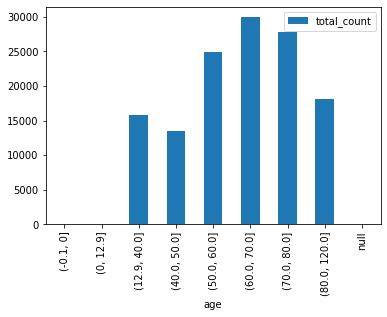

In [16]:
_agedist(df_total, 'total')

#### Add age and bmi categories

In [17]:
#df_total.insert(5,'bmi_cat', BMI_BINS(df_total))

In [18]:
df_total.insert(5,'age_group',AGE_BINS(df_total))

In [19]:
df_total.columns

Index(['encounter_id', 'age', 'gender', 'height', 'weight', 'age_group'], dtype='object')

In [20]:
df_total

,encounter_id,age,gender,height,weight,age_group
0,214826,68.0,M,180.3,73.9,"(60.0, 70.0]"
1,246060,77.0,F,160.0,70.2,"(70.0, 80.0]"
2,276985,25.0,F,172.7,95.3,"(12.9, 40.0]"
3,262220,81.0,F,165.1,61.7,"(80.0, 120.0]"
5,182697,67.0,M,190.5,100.0,"(60.0, 70.0]"
...,...,...,...,...,...,...
10229,143750,36.0,F,170.1,108.6,"(12.9, 40.0]"
10230,143813,61.0,F,160.0,82.3,"(60.0, 70.0]"
10231,137126,74.0,F,165.1,62.0,"(70.0, 80.0]"
10232,135652,90.0,F,160.0,50.9,"(80.0, 120.0]"


In [21]:
df_total['age_group'].value_counts()

(60.0, 70.0]     29939
(70.0, 80.0]     27811
(50.0, 60.0]     24937
(80.0, 120.0]    18175
(12.9, 40.0]     15771
(40.0, 50.0]     13424
(-0.1, 0]            0
(0, 12.9]            0
Name: age_group, dtype: int64

In [22]:
df_total

,encounter_id,age,gender,height,weight,age_group
0,214826,68.0,M,180.3,73.9,"(60.0, 70.0]"
1,246060,77.0,F,160.0,70.2,"(70.0, 80.0]"
2,276985,25.0,F,172.7,95.3,"(12.9, 40.0]"
3,262220,81.0,F,165.1,61.7,"(80.0, 120.0]"
5,182697,67.0,M,190.5,100.0,"(60.0, 70.0]"
...,...,...,...,...,...,...
10229,143750,36.0,F,170.1,108.6,"(12.9, 40.0]"
10230,143813,61.0,F,160.0,82.3,"(60.0, 70.0]"
10231,137126,74.0,F,165.1,62.0,"(70.0, 80.0]"
10232,135652,90.0,F,160.0,50.9,"(80.0, 120.0]"


#### Convert categorical columns to dummies

In [23]:
df_new = df_total[['gender', 'height', 'weight']] #, 'ethnicity', 'bmi_cat']] #
df_new

,gender,height,weight
0,M,180.3,73.9
1,F,160.0,70.2
2,F,172.7,95.3
3,F,165.1,61.7
5,M,190.5,100.0
...,...,...,...
10229,F,170.1,108.6
10230,F,160.0,82.3
10231,F,165.1,62.0
10232,F,160.0,50.9


In [24]:
import pandas as pd
df_new = pd.get_dummies(df_new, prefix = ['gender'], drop_first=True) # , 'ethnicity', 'bmi_cat'

In [25]:
df_new

,height,weight,gender_M
0,180.3,73.9,1
1,160.0,70.2,0
2,172.7,95.3,0
3,165.1,61.7,0
5,190.5,100.0,1
...,...,...,...
10229,170.1,108.6,0
10230,160.0,82.3,0
10231,165.1,62.0,0
10232,160.0,50.9,0


In [26]:
df_index = pd.concat([df_new, df_total['age_group']], join = 'outer', axis = 1) 

#### Convert age groups from categorical to numerical

In [27]:
def mapintfromgroup(age_group):
    print(age_group)
    
    if age_group == '(12.9, 40.0]':
        return 1
    elif age_group == '(40.0, 50.0]':
        return 2
    elif age_group == '(50.0, 60.0]':
        return 3
    elif age_group == '(60.0, 70.0]':
        return 4
    elif age_group == '(70.0, 80.0]':
        return 5
    elif age_group == '(80.0, 120.0]':
        return 6
    else:
        return 7
    '''
    if age_group == '(-0.1, 0]':
         return 1
    elif age_group == '(0, 12.9]':
        return 2
    elif age_group == '(12.9, 17.9]':
        return 3
    elif age_group == '(17.9, 30.0]':
        return 4
    elif age_group == '(30.0, 50.0]':
        return 5
    elif age_group == '(50.0, 70.0]':
        return 6
    elif age_group == '(70.0, 90.0]':
        return 7
    elif age_group == '(90.0, 120.0]':
        return 8
    else:
        return 9
    '''

In [28]:
df_index['age'] = df_index['age_group'].apply(lambda age_group: mapintfromgroup(age_group))

(-0.1, 0]
(0, 12.9]
(12.9, 40.0]
(40.0, 50.0]
(50.0, 60.0]
(60.0, 70.0]
(70.0, 80.0]
(80.0, 120.0]


In [29]:
df_index

,height,weight,gender_M,age_group,age
0,180.3,73.9,1,"(60.0, 70.0]",4
1,160.0,70.2,0,"(70.0, 80.0]",5
2,172.7,95.3,0,"(12.9, 40.0]",1
3,165.1,61.7,0,"(80.0, 120.0]",6
5,190.5,100.0,1,"(60.0, 70.0]",4
...,...,...,...,...,...
10229,170.1,108.6,0,"(12.9, 40.0]",1
10230,160.0,82.3,0,"(60.0, 70.0]",4
10231,165.1,62.0,0,"(70.0, 80.0]",5
10232,160.0,50.9,0,"(80.0, 120.0]",6


In [30]:
df_new = df_index.drop(columns=['age_group'])

In [31]:
df_new

,height,weight,gender_M,age
0,180.3,73.9,1,4
1,160.0,70.2,0,5
2,172.7,95.3,0,1
3,165.1,61.7,0,6
5,190.5,100.0,1,4
...,...,...,...,...
10229,170.1,108.6,0,1
10230,160.0,82.3,0,4
10231,165.1,62.0,0,5
10232,160.0,50.9,0,6


In [32]:

# split into input and output elements
data = df_new.values


In [33]:
data

array([[180.3,  73.9,   1. ,   4. ],
       [160. ,  70.2,   0. ,   5. ],
       [172.7,  95.3,   0. ,   1. ],
       ...,
       [165.1,  62. ,   0. ,   5. ],
       [160. ,  50.9,   0. ,   6. ],
       [177.8,  81. ,   1. ,   1. ]])

In [34]:
X, y = data[:, :-1], data[:, -1]

In [35]:
type(X); type(y)

numpy.ndarray

In [36]:
X

array([[180.3,  73.9,   1. ],
       [160. ,  70.2,   0. ],
       [172.7,  95.3,   0. ],
       ...,
       [165.1,  62. ,   0. ],
       [160. ,  50.9,   0. ],
       [177.8,  81. ,   1. ]])

In [37]:
y

array([4., 5., 1., ..., 5., 6., 1.])

Class=3, n=29939 (23.020%)
Class=4, n=27811 (21.384%)
Class=0, n=15771 (12.126%)
Class=5, n=18175 (13.975%)
Class=2, n=24937 (19.174%)
Class=1, n=13424 (10.322%)


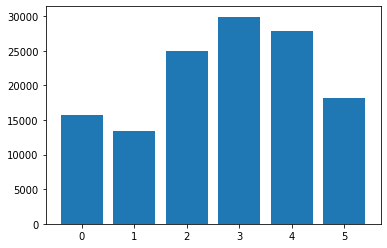

In [38]:
# label encode the target variable
y = LabelEncoder().fit_transform(y)
# summarize distribution
counter = Counter(y)
for k,v in counter.items():
	per = v / len(y) * 100
	print('Class=%d, n=%d (%.3f%%)' % (k, v, per))
# plot the distribution
pyplot.bar(counter.keys(), counter.values())
pyplot.show()

## Without oversampling

In [39]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DS_SIZE, random_state=0)
print(X_train.shape[0],X_test.shape[0])

104045 26012


0.24181147162847916


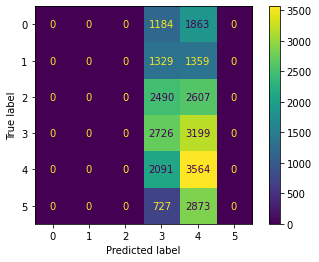

In [40]:
acc_WO_DT = predictWithDecisionTree(X_train, y_train, X_test, y_test)

0.23739043518376135


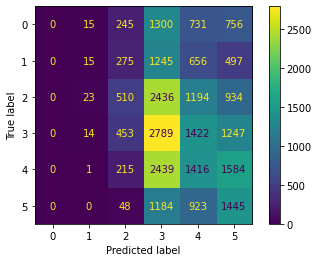

In [41]:
acc_NO_NB = predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test)

### Oversampling using SMOTE

Class=3, n=29939 (16.667%)
Class=4, n=29939 (16.667%)
Class=0, n=29939 (16.667%)
Class=5, n=29939 (16.667%)
Class=2, n=29939 (16.667%)
Class=1, n=29939 (16.667%)


<BarContainer object of 6 artists>

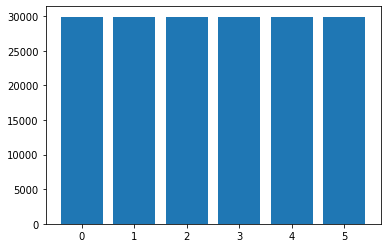

In [42]:
X, y, counter = oversample(X, y)
# plot the distribution
pyplot.bar(counter.keys(), counter.values())

In [43]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size=TEST_DS_SIZE, random_state=0)
print(X_train.shape[0],X_test.shape[0])

143707 35927


0.21610487933865893


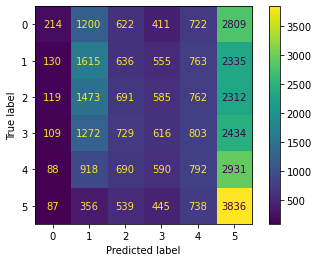

In [44]:
acc_NO_NB = predictWithGaussianNaiveBayes(X_train, y_train, X_test, y_test)